In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from copy import deepcopy
from itertools import product
from pprint import pprint
from itertools import islice, combinations
import re

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import seaborn as sns
import shapely
from matplotlib import cm, colors
from shapely.ops import cascaded_union
from tqdm import tqdm
from util import *

In [3]:
ox.config(use_cache=True)

/Users/schmidmt/code/d2p-sp22/.venv/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


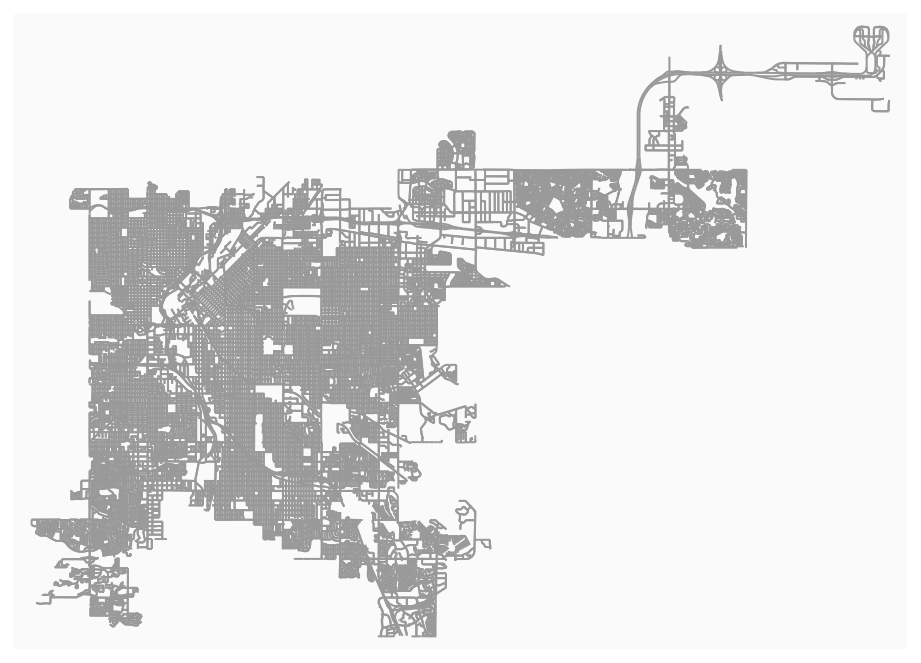

In [4]:
G = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0, bgcolor="#fafafa")

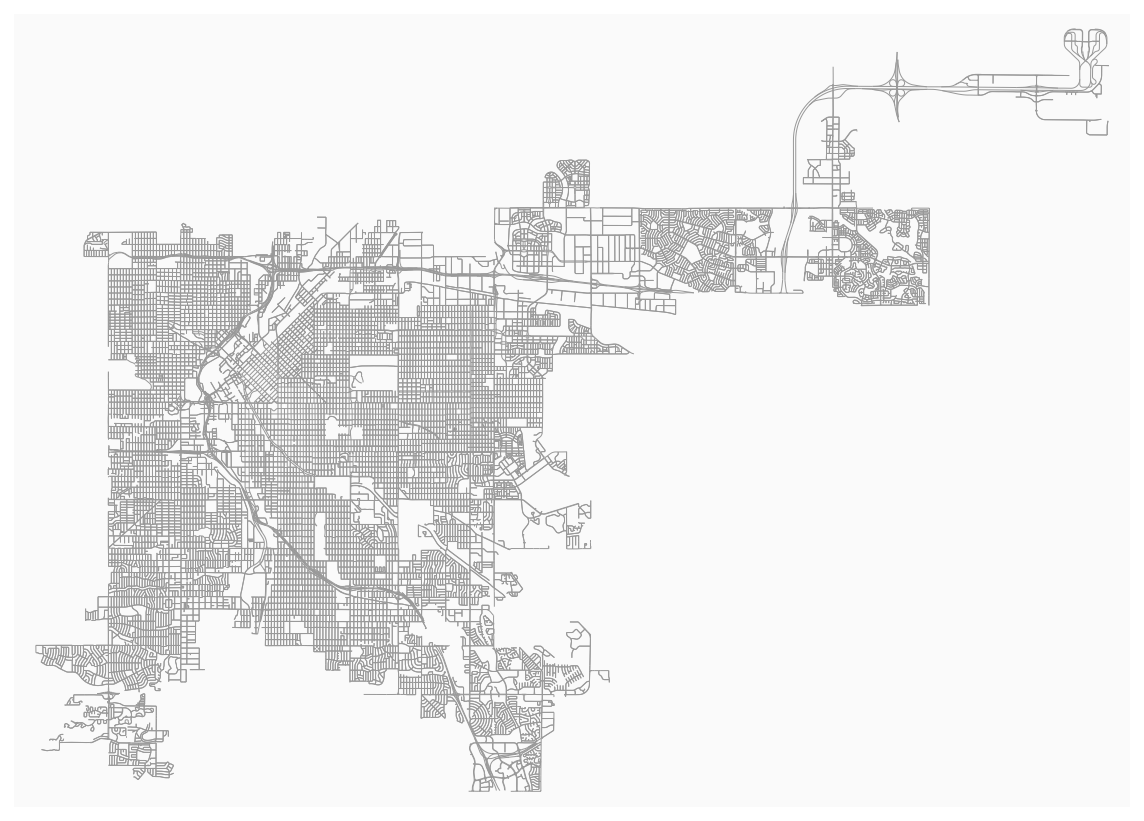

In [5]:
fig, ax = ox.plot_graph(G, node_size=0, bgcolor="#fafafa", figsize=(10, 10), edge_linewidth=0.5)

In [7]:
G = ox.speed.add_edge_speeds(
    G,
    hwy_speeds={
        "residential": 40.23,
    },
)

In [8]:
neighborhoods = gpd.read_file(
    "../data/statistical_neighborhoods.gdb", driver="OpenFileGDB"
)

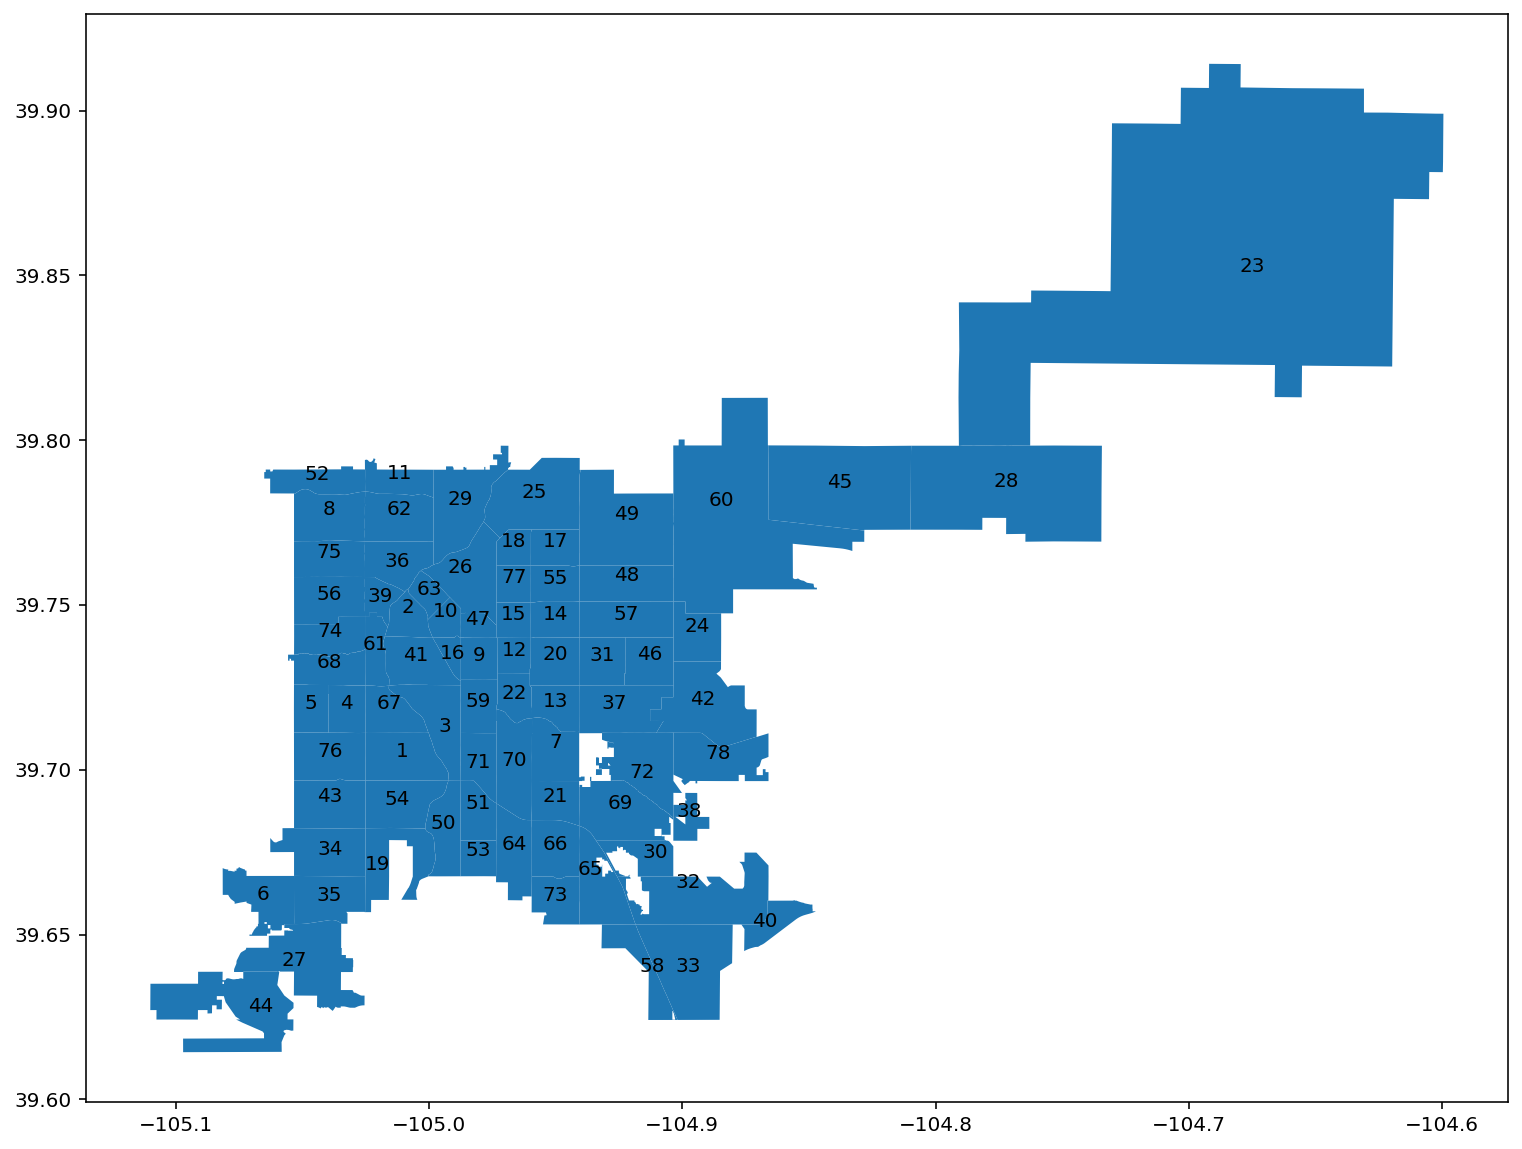

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
neighborhoods.plot(ax=ax, legend=True)
for idx, row in neighborhoods.iterrows():
    plt.annotate(
        text=row["NBHD_ID"],
        xy=row["geometry"].representative_point().coords[0],
        horizontalalignment="center",
    )

In [10]:
neighborhoods[neighborhoods["NBHD_ID"] == 10]

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,SHAPE_Length,SHAPE_Area,geometry
48,10,CBD,None,None,0.042534,0.000117,"MULTIPOLYGON (((-104.98740 39.74736, -104.9874..."


In [11]:
DOWNTOWN_IDS = [63, 10, 26, 47]
SOUTH_CENTRAL = [9, 59, 12, 22, 20, 13]
OVERLAND = [50]
MY_NEIGHBORHOOD = [50, 51, 53]
ALL = neighborhoods["NBHD_ID"]

In [12]:
neighborhoods_of_interest = neighborhoods[neighborhoods["NBHD_ID"].isin(ALL)]
neighborhoods_of_interest

,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,SHAPE_Length,SHAPE_Area,geometry
0,2,Auraria,None,None,0.055662,0.000176,"MULTIPOLYGON (((-105.00042 39.74552, -105.0004..."
1,21,Cory - Merrill,None,None,0.063099,0.000228,"MULTIPOLYGON (((-104.94070 39.69540, -104.9407..."
2,7,Belcaro,None,None,0.077481,0.000317,"MULTIPOLYGON (((-104.94070 39.71156, -104.9406..."
3,70,Washington Park,None,None,0.090445,0.000411,"MULTIPOLYGON (((-104.95931 39.71566, -104.9593..."
4,71,Washington Park West,None,None,0.066412,0.000237,"MULTIPOLYGON (((-104.97342 39.68982, -104.9735..."
...,...,...,...,...,...,...,...
73,77,Whittier,None,None,0.049779,0.000153,"MULTIPOLYGON (((-104.95977 39.75072, -104.9603..."
74,18,Cole,None,None,0.046895,0.000139,"MULTIPOLYGON (((-104.95975 39.76199, -104.9603..."
75,76,Westwood,NEST,None,0.085487,0.000407,"MULTIPOLYGON (((-105.03970 39.71125, -105.0384..."
76,62,Sunnyside,None,None,0.082679,0.000388,"MULTIPOLYGON (((-104.99818 39.78256, -104.9982..."


In [13]:
neighborhoods_of_interest_poly = cascaded_union(
    neighborhoods_of_interest.geometry.values
)
map_a = ox.graph.graph_from_polygon(
    neighborhoods_of_interest_poly, network_type="drive"
)

/var/folders/0_/t8n56nmx19sbvj35c9jk7stm0000gn/T/ipykernel_40523/432650369.py:1: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  neighborhoods_of_interest_poly = cascaded_union(


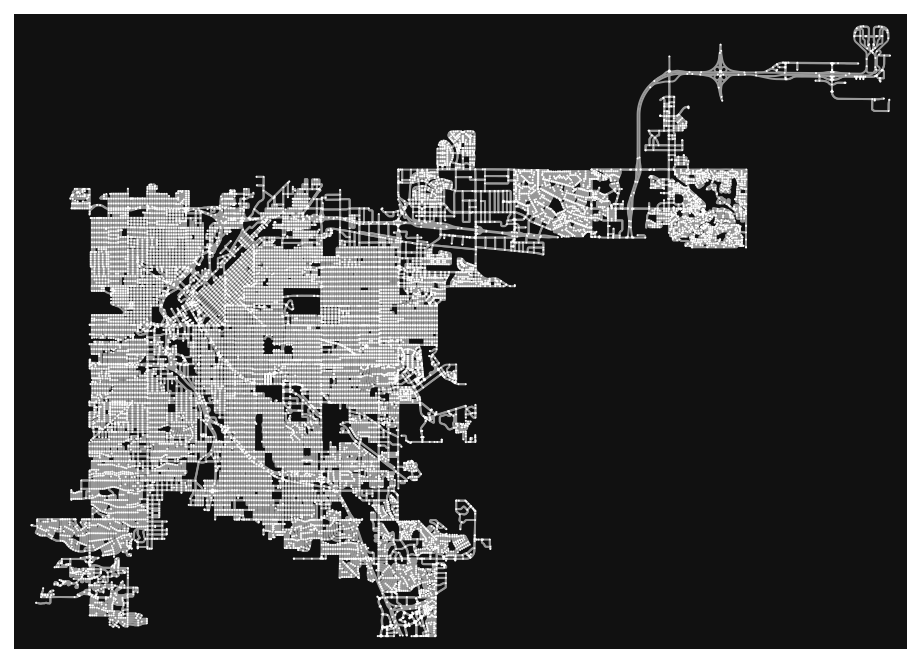

In [14]:
fig, ax = ox.plot_graph(map_a, node_size=1)

boundary_nodes = set()
for node in map_a.nodes:
    if map_a.degree(node) != G.degree(node):
        boundary_nodes.add(node)

nc_terminal = ["yellow" if n in boundary_nodes else "k" for n in map_a.nodes]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=1,
    node_color=nc_terminal,
    show=False,
    bgcolor="white",
    figsize=(10, 10),
)

In [15]:
map_a_nodes, map_a_edges = ox.utils_graph.graph_to_gdfs(map_a, nodes=True, edges=True)

boundary_nodes_df = map_a_nodes.loc[boundary_nodes]

most_distant_pairs = []
for node in boundary_nodes:
    furthest = boundary_nodes_df.distance(boundary_nodes_df.loc[node].geometry).idxmax()
    most_distant_pairs.append((node, furthest))

nc_terminal = ["yellow" if n == most_distant_pairs[10][0] or n == most_distant_pairs[10][1] else "k" for n in map_a.nodes]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=1,
    node_color=nc_terminal,
    show=False,
    bgcolor="white",
    figsize=(10, 10),
)

In [16]:
map_a = ox.speed.add_edge_speeds(
    map_a,
    hwy_speeds={
        "residential": 40.23,
        "tertiary": 56.33,
    },
)

SPEED_RE = re.compile(r"^(\d+) mph$")
for (u, v) in map_a.edges():
    edge_data = map_a.get_edge_data(u, v)
    if "max_speed" in edge_data:
        m = re.match(edge_data["max_speed"])
        if m:
            speed_mph = int(m.group(1))
            edge_data["speed_kph"] = speed_mph * 1.609
        else:
            print(u, v, data)

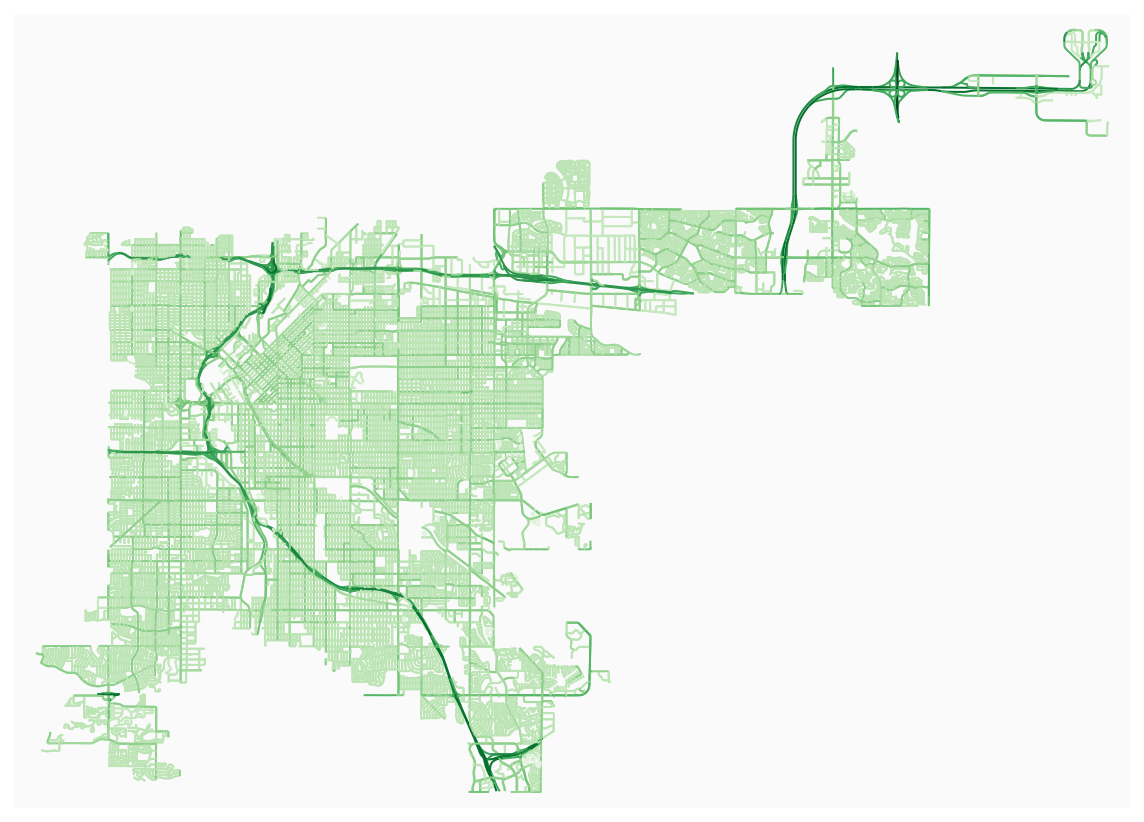

In [26]:
ec = ox.plot.get_edge_colors_by_attr(map_a, "speed_kph", cmap="Greens")
fig, ax = ox.plot_graph(map_a, node_alpha=0, edge_color=ec, bgcolor="#fafafa", figsize=(10, 10))

In [18]:
map_a = drive_network_to_capacitated_network(map_a)

In [19]:
map_a_nodes, map_a_edges = ox.utils_graph.graph_to_gdfs(map_a, nodes=True, edges=True)

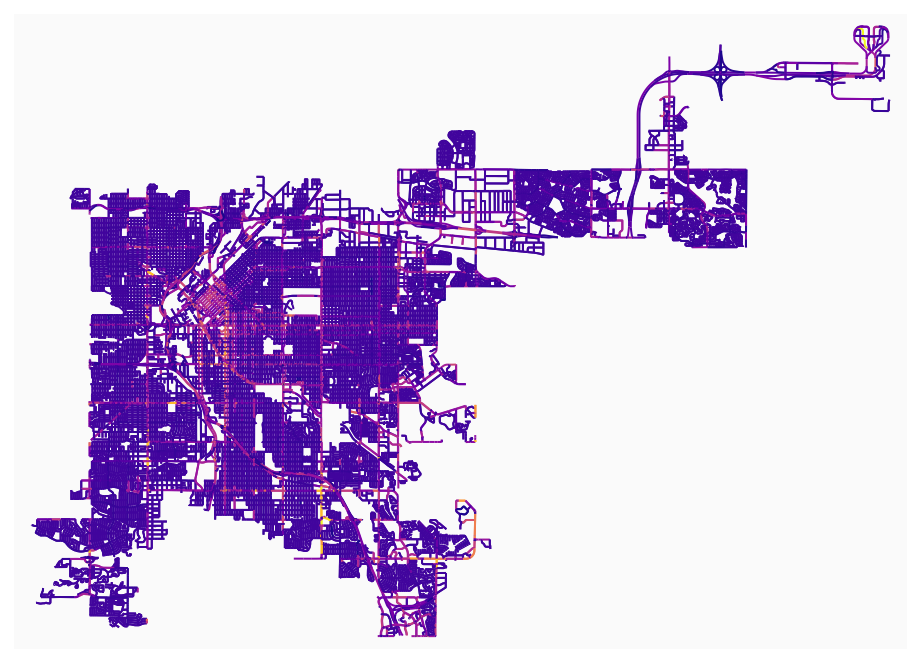

In [20]:
ec = ox.plot.get_edge_colors_by_attr(map_a, "capacity", cmap="plasma", na_color="red")
fig, ax = ox.plot_graph(map_a, node_alpha=0, edge_color=ec, bgcolor="#fafafa")

In [21]:
for (u, v) in map_a.edges():
    data = map_a.get_edge_data(u, v)
    if "capacity" not in data[0] or np.isnan(data[0]["capacity"]):
        print(data)
        if "highway" in data:
            print(u, v, data["highway"])
        else:
            print(u, v, "Unknown")

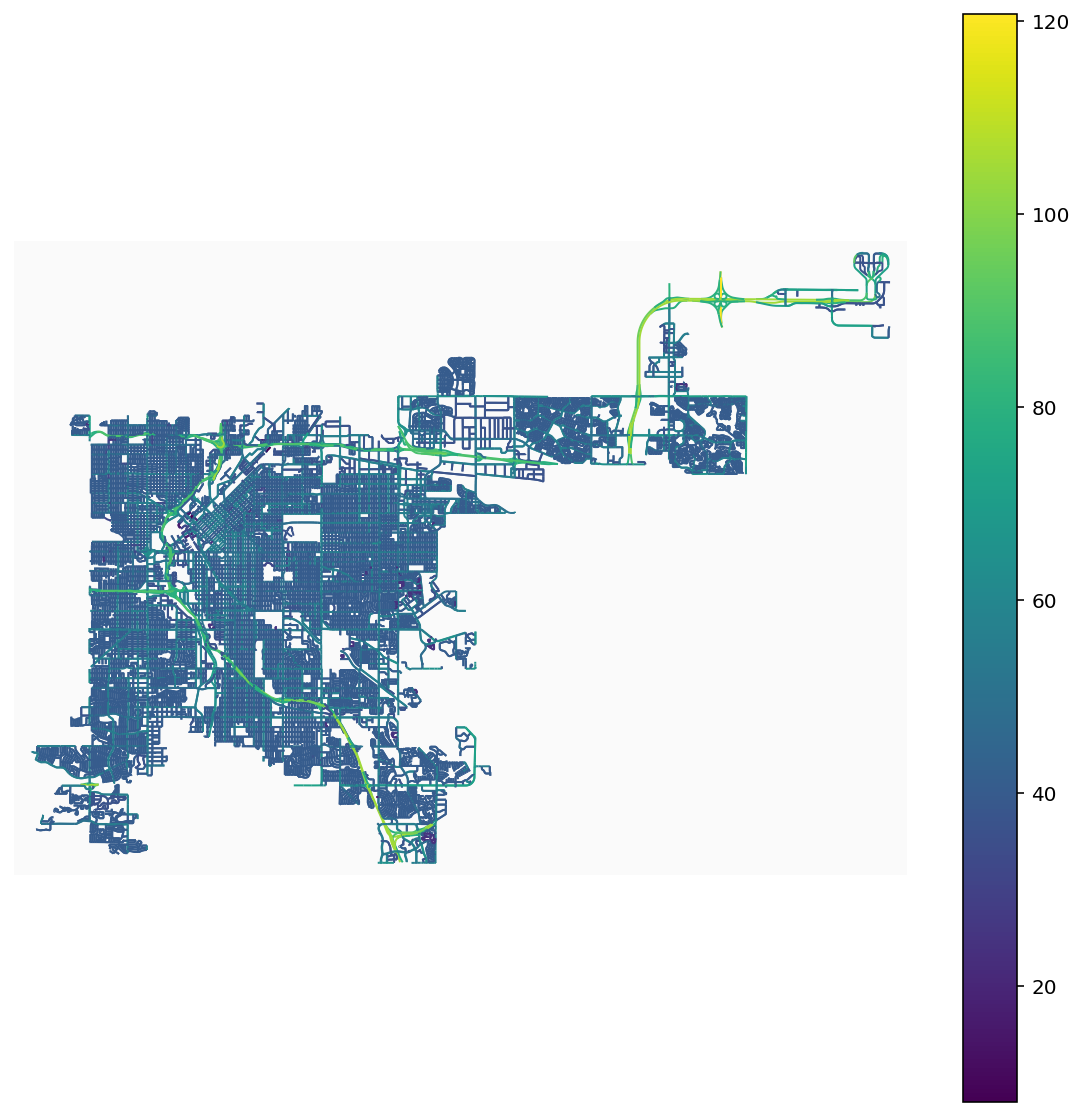

In [22]:
arc_speeds = [c for (u, v, c) in map_a.edges(data="speed_kph")]

norm = colors.Normalize()
norm.autoscale(arc_speeds)
ec_arc_speeds = [cm.viridis(norm(f)) for f in arc_speeds]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=0,
    edge_color=ec_arc_speeds,
    show=False,
    bgcolor="#fafafa",
    figsize=(10, 10),
)

cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cm.viridis), ax=ax, orientation="vertical"
)

Text(0.5, 1.0, 'Est. Capacities for Denver Roads')

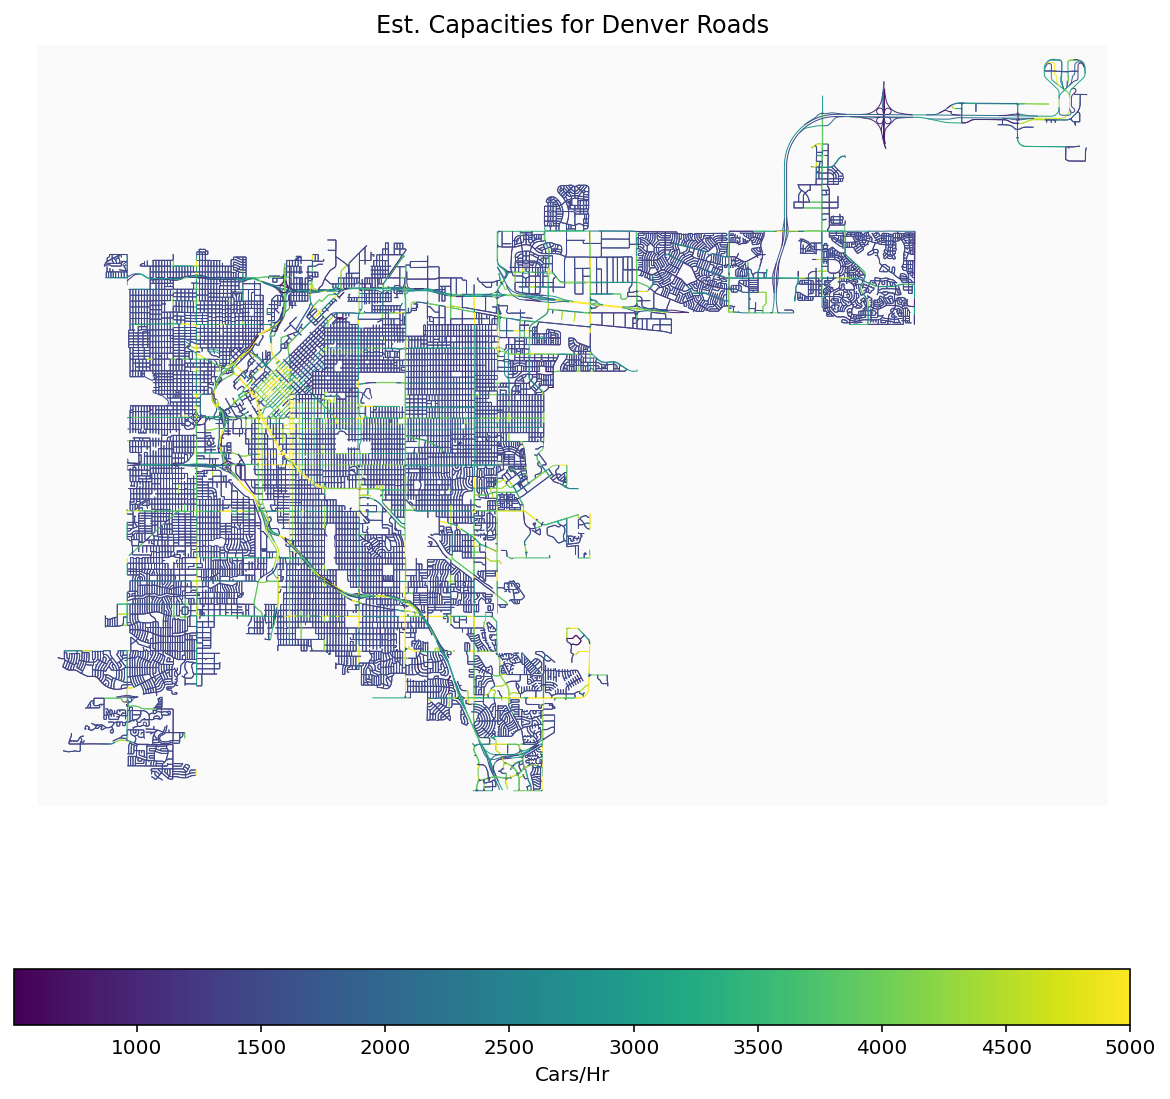

In [30]:
arc_capacities = [np.min([c, 5000]) for (u, v, c) in map_a.edges(data="capacity")]

norm = colors.Normalize()
norm.autoscale(arc_capacities)
ec_arc_capacities = [cm.viridis(norm(f)) for f in arc_capacities]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=0,
    edge_color=ec_arc_capacities,
    show=False,
    bgcolor="#fafafa",
    figsize=(10, 10),
    edge_linewidth=0.5
)

cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cm.viridis), ax=ax, orientation="horizontal"
)
cb.ax.set_xlabel("Cars/Hr")

ax.set_title("Est. Capacities for Denver Roads")

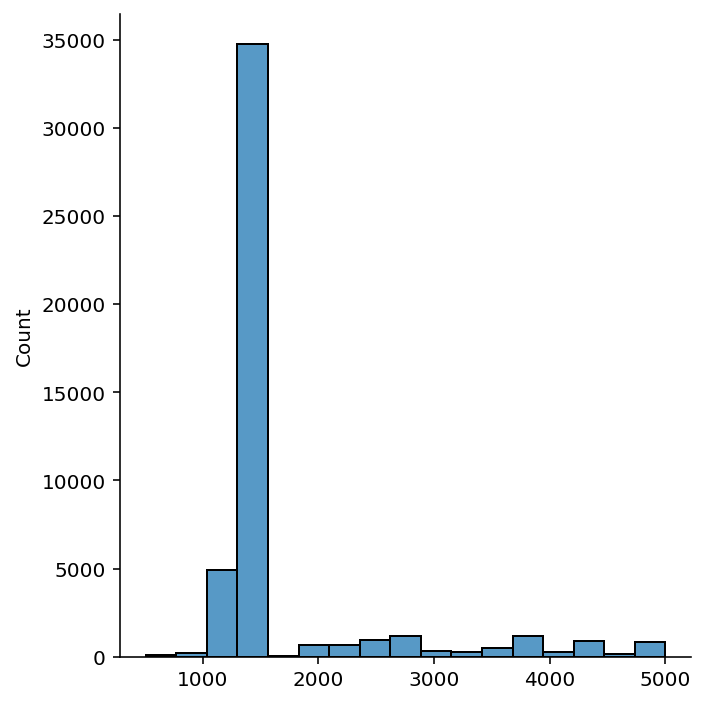

In [24]:
sns.displot(arc_capacities)

impacts = all_arc_removal_impact(nx.DiGraph(map_a), map_a.nodes)

impacts = given_arc_removal_impact(nx.DiGraph(map_a), most_distant_pairs)

arc_max_impact = [np.max(impacts[(u, v)]) + 1 for (u, v) in map_a.edges()]

norm = colors.LogNorm()
norm.autoscale(arc_max_impact)
ec_max_impact = [cm.plasma(norm(f)) for f in arc_max_impact]

fig, ax = ox.plot_graph(
    map_a,
    node_alpha=0.5,
    edge_color=ec_max_impact,
    show=False,
    bgcolor="black",
    figsize=(10, 10),
)

cb = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cm.plasma), ax=ax, orientation="vertical"
)